In [1]:
from covasim import interventions
import covasim as cv
import covasim.utils as cvu
import numpy.random as npr

Notebook contains some simple code to run mass screening style interventions. Used for developing the time-varying test sensitivity code

## No mass testing

Initializing sim with 50000 people for 58 days
  Running 2020-02-01 ( 0/58) (0.72 s)  ———————————————————— 2%
  Running 2020-02-11 (10/58) (0.78 s)  •••————————————————— 19%
  Running 2020-02-21 (20/58) (0.85 s)  •••••••————————————— 36%
  Running 2020-03-02 (30/58) (0.93 s)  ••••••••••—————————— 53%
  Running 2020-03-12 (40/58) (1.04 s)  •••••••••••••——————— 69%
  Running 2020-03-22 (50/58) (1.19 s)  •••••••••••••••••——— 86%
Simulation summary:
   35847 cumulative infections
   31819 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
   20134 cumulative recoveries
   20971 cumulative symptomatic cases
    1358 cumulative severe cases
     418 cumulative critical cases
      85 cumulative deaths
       0 cumulative quarantined people



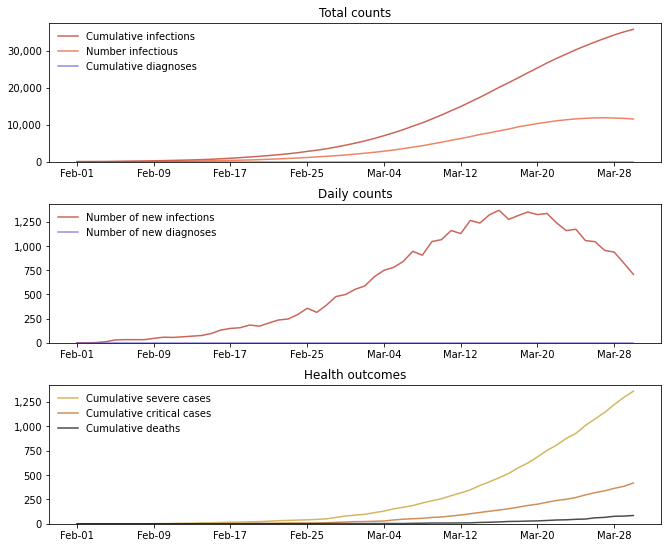

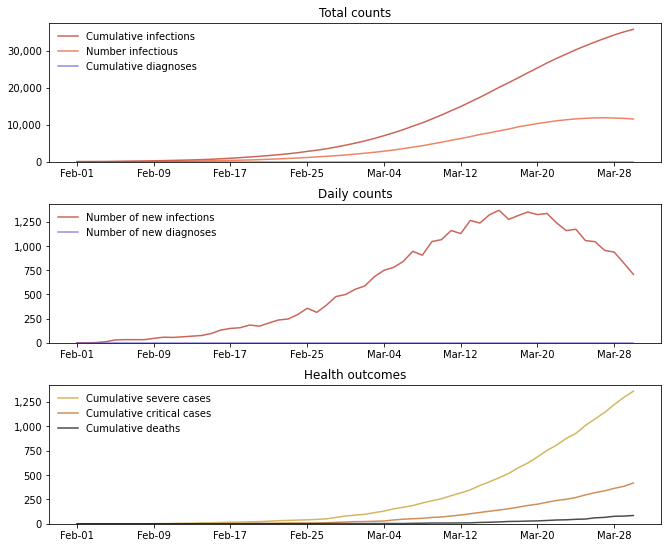

In [17]:
# ~~ begin by running the default model to check that everything works correctly ~~

# Define the default parameters
pars = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-02-01',
    end_day   = '2020-03-30',
)

# Define the simulations
sim1 = cv.Sim(pars)

sim1.run()

sim1.plot()

Looks like everything is working to me.

## Mass LFA screening implementation 1
This sets up a custom intervention class for mass LFA testing as an example. A proportion of the population are selected to get testing very regularly with lateral flow tests.

This implementation uses the OLD implementation of testing in the model. 

In [14]:
class lfa_screening_old(cv.Intervention):

    def __init__(self, screened_proportion, every_n_days, *args, **kwargs):
        super().__init__(**kwargs)  # This line must be included
        self._store_args()          # So must this one

        # screening parameters
        self.screened_proportion    = screened_proportion
        self.every_n_days           = every_n_days
        return
    
    def initialize(self, sim):
        """
        Parameters that need to be intialised at the start of the simulation.

        In our case, this corresponds to choosing a proportion of the population to be lfa screened every n days.
        """
        pop_size    = sim["pop_size"]

        # we want to have an index of which individuals are being LFA screened
        # we create a random vector of True/False values with size equal to population size 
        being_lfa_screened = npr.choice(
            a       = [True, False],
            size    = pop_size,
            p       = [self.screened_proportion, 1 - self.screened_proportion]
        )

        # the index of individuals who are being screened regularly from the random vector
        self.being_lfa_screened = cvu.true(being_lfa_screened)

        self.initialized = True

    def apply(self, sim):
        """
        Applies the testing interventions

        If the current simulation time is a multiple of self.every_n_days, then we perform mass testing with low sensitivity
        on a subset of the population.
        """

        if (sim.t % self.every_n_days) == 0:
            
            # sanity check
            print(f'lfa screening occured at day {sim.t}')

            # 
            sim.people.test(
                inds = self.being_lfa_screened,
                test_sensitivity = 0.5
            )

        return

Now we run the intervention to see if everything works.

Initializing sim with 50000 people for 58 days
  Running 2020-02-01 ( 0/58) (0.61 s)  ———————————————————— 2%
lfa screening occured at day 0
lfa screening occured at day 3
lfa screening occured at day 6
lfa screening occured at day 9
  Running 2020-02-11 (10/58) (0.69 s)  •••————————————————— 19%
lfa screening occured at day 12
lfa screening occured at day 15
lfa screening occured at day 18
  Running 2020-02-21 (20/58) (0.76 s)  •••••••————————————— 36%
lfa screening occured at day 21
lfa screening occured at day 24
lfa screening occured at day 27
  Running 2020-03-02 (30/58) (0.86 s)  ••••••••••—————————— 53%
lfa screening occured at day 30
lfa screening occured at day 33
lfa screening occured at day 36
lfa screening occured at day 39
  Running 2020-03-12 (40/58) (0.99 s)  •••••••••••••——————— 69%
lfa screening occured at day 42
lfa screening occured at day 45
lfa screening occured at day 48
  Running 2020-03-22 (50/58) (1.15 s)  •••••••••••••••••——— 86%
lfa screening occured at day 5

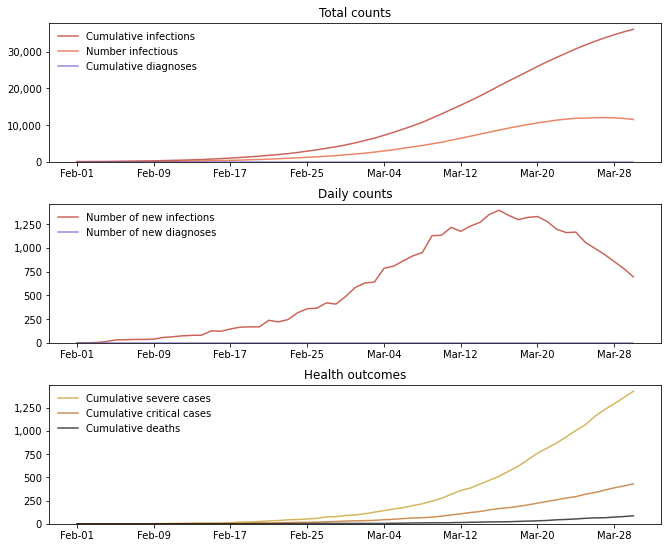

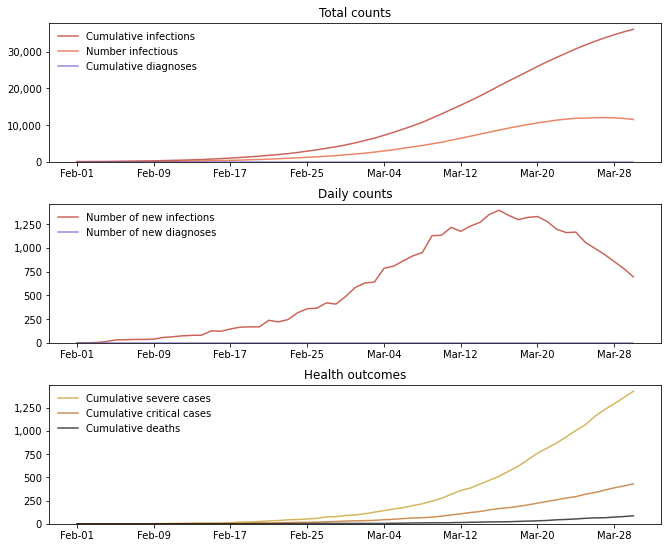

In [16]:
# ~~ sim 2 ~~ 

# initialise an lfa screening intervention to be passed to the model
lfa_screening_not_time_varying = lfa_screening_old(
    screened_proportion=0.5,
    every_n_days=3
    )

# Define the default parameters
pars2 = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-02-01',
    end_day   = '2020-03-30',
    interventions = [lfa_screening_not_time_varying]
)

# Define the simulations
sim2 = cv.Sim(pars2)

sim2.run()

sim2.plot()

In [9]:
# we create a testing intervention where a fraction of the population gets tested regularly
# this one uses the old testing intervention
class lfa_screening_new(cv.Intervention):

    def __init__(self, screened_proportion, every_n_days, *args, **kwargs):
        super().__init__(**kwargs)  # This line must be included
        self._store_args()          # So must this one

        # screening parameters
        self.screened_proportion    = screened_proportion
        self.every_n_days           = every_n_days
        return
    
    def initialize(self, sim):
        """
        Parameters that need to be intialised at the start of the simulation.

        In our case, this corresponds to choosing a proportion of the population to be lfa screened.
        """
        pop_size    = sim["pop_size"]

        # we want to have an index of which individuals are being LFA screened
        # we create a random vector of True/False values with size equal to population size 
        being_lfa_screened = npr.choice(
            a       = [True, False],
            size    = pop_size,
            p       = [self.screened_proportion, 1 - self.screened_proportion]
        )

        # the index of individuals who are being screened regularly from the random vector
        self.initialized = True
        self.being_lfa_screened = cvu.true(being_lfa_screened)

    def apply(self, sim):
        """
        Applies the testing interventions

        If the current simulation time is a multiple of self.every_n_days, then we perform mass testing with low sensitivity
        on a subset of the population.
        """

        if (sim.t % self.every_n_days) == 0:
            
            # sanity check
            print(f'lfa screening occured at day {sim.t}')

            # 
            sim.people.newTest(
                inds = self.being_lfa_screened,
                test_type = 'lfa'
            )

        return

In [10]:
# initialise an lfa screening intervention to be passed to the model
lfa_screening_time_varying = lfa_screening_new(
    screened_proportion=0.5,
    every_n_days=3
    )

# Define the default parameters
pars2 = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-02-01',
    end_day   = '2020-03-30',
    interventions = [lfa_screening_time_varying]
)

# Define the simulations
sim2 = cv.Sim(pars2)

sim2.run()

Initializing sim with 50000 people for 58 days
  Running 2020-02-01 ( 0/58) (0.64 s)  ———————————————————— 2%
lfa screening occured at day 0


ValueError: need at least one array to concatenate

I wasn't able to get the above code to run properly. I think the calculation is correct, but the model was expecting data to be in a different format for it to be able to use the results, i.e; it was expecting an array of True/False for each individual who got tested.

I made a slight reimplementation to try and run the testing intervention, to make it easy to compare differences I've implemented it in TimeVaryingTestSensitivity.

In [10]:
# we create a testing intervention where a fraction of the population gets tested regularly
# this one uses the old testing intervention
class lfa_screening_mf_implementation(cv.Intervention):

    def __init__(self, screened_proportion, every_n_days, *args, **kwargs):
        super().__init__(**kwargs)  # This line must be included
        self._store_args()          # So must this one

        # screening parameters
        self.screened_proportion    = screened_proportion
        self.every_n_days           = every_n_days
        return
    
    def initialize(self, sim):
        """
        Parameters that need to be intialised at the start of the simulation.

        In our case, this corresponds to choosing a proportion of the population to be lfa screened.
        """
        pop_size    = sim["pop_size"]

        # we want to have an index of which individuals are being LFA screened
        # we create a random vector of True/False values with size equal to population size 
        being_lfa_screened = npr.choice(
            a       = [True, False],
            size    = pop_size,
            p       = [self.screened_proportion, 1 - self.screened_proportion]
        )

        # the index of individuals who are being screened regularly from the random vector
        self.initialized = True
        self.being_lfa_screened = cvu.true(being_lfa_screened)

    def apply(self, sim):
        """
        Applies the testing interventions

        If the current simulation time is a multiple of self.every_n_days, then we perform mass testing with low sensitivity
        on a subset of the population.
        """

        if (sim.t % self.every_n_days) == 0:
            
            # sanity check
            print(f'lfa screening occured at day {sim.t}')

            # 
            sim.people.TestTimeVaryingSensitivity(
                inds = self.being_lfa_screened,
                test_type = 'lfa'
            )

        return

In [11]:
# initialise an lfa screening intervention to be passed to the model
lfa_screening_time_varying_2 = lfa_screening_mf_implementation(
    screened_proportion=0.5,
    every_n_days=3
    )

# Define the default parameters
pars3 = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-02-01',
    end_day   = '2020-03-30',
    interventions = [lfa_screening_time_varying_2]
)

# Define the simulations
sim3 = cv.Sim(pars3)

sim3.run()

Initializing sim with 50000 people for 58 days
  Running 2020-02-01 ( 0/58) (0.60 s)  ———————————————————— 2%
lfa screening occured at day 0
There were 0 positive tests
lfa screening occured at day 3
There were 0 positive tests
lfa screening occured at day 6
There were 9 positive tests
lfa screening occured at day 9
There were 17 positive tests
  Running 2020-02-11 (10/58) (0.69 s)  •••————————————————— 19%
lfa screening occured at day 12
There were 23 positive tests
lfa screening occured at day 15
There were 33 positive tests
lfa screening occured at day 18
There were 36 positive tests
  Running 2020-02-21 (20/58) (0.79 s)  •••••••————————————— 36%
lfa screening occured at day 21
There were 78 positive tests
lfa screening occured at day 24
There were 118 positive tests
lfa screening occured at day 27
There were 165 positive tests
  Running 2020-03-02 (30/58) (0.90 s)  ••••••••••—————————— 53%
lfa screening occured at day 30
There were 227 positive tests
lfa screening occured at day 33

Sim(<no label>; 2020-02-01 to 2020-03-30; pop: 50000 random; epi: 34286⚙, 64☠)